In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import keras
from keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, BatchNormalization
from keras.models import Model
from keras.layers import Concatenate, BatchNormalization
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [2]:
# Importing training data
train_aud_x = np.load('x_train_sp.npy')
train_img_x = np.load('x_train_wr.npy')
train_y = pd.read_csv('y_train.csv')

In [4]:
y_train = np.array(train_y['label'])

In [5]:
# Creating a 2D labels array, 10 sized array with the label value marked as 1
y_train_2d = np.array([[1 if i == digit else 0 for i in range(10)] for digit in y_train])

In [7]:
# Split the data set to training, vakidation and testing
X_train_rest_aud, X_test_aud, y_train_rest_aud, y_test_aud = train_test_split(train_aud_x, y_train_2d, test_size=0.1, random_state=42)

X_train_aud, X_val_aud, y_train_aud, y_val_aud = train_test_split(X_train_rest_aud, y_train_rest_aud, test_size=0.2/0.9, random_state=42)

In [8]:
# Initializing the CNN model for audio data
model_aud = Sequential()

# Adding covolution layers and max pooling layers
model_aud.add(Conv1D(16, kernel_size=2, activation='relu', input_shape=(507, 1)))
model_aud.add(BatchNormalization())
model_aud.add(MaxPooling1D(pool_size=2))
model_aud.add(Conv1D(32, kernel_size=2, activation='relu'))
model_aud.add(BatchNormalization())
model_aud.add(Flatten())
# Neural layer added after convolution
model_aud.add(Dense(64, activation='relu'))
model_aud.add(BatchNormalization())
model_aud.add(Dense(10, activation='softmax'))

# Use adam optimizer to tune, cross entropy as loss function and accuray as evaluation metric
model_aud.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model on audio data set
model_aud.fit(X_train_aud, y_train_aud, batch_size=64, epochs=20, 
              validation_data=(X_val_aud, y_val_aud), verbose=0)

In [9]:
# Split the image data set to training, validation and testing
X_train_rest_img, X_test_img, y_train_rest_img, y_test_img = train_test_split(train_img_x, y_train_2d, test_size=0.1, random_state=42)

X_train_img, X_val_img, y_train_img, y_val_img = train_test_split(X_train_rest_img, y_train_rest_img, test_size=0.2/0.9, random_state=42)

In [10]:
num_classes = 10
input_shape = (28, 28, 1)

# Normalize the image data set
X_train_img = X_train_img.astype("float32") / 255
X_val_img = X_val_img.astype("float32") / 255
X_test_img = X_test_img.astype("float32") / 255
# Reshape the 1D array to 2D array to represent the image
X_train_img = X_train_img.reshape(-1, 28, 28)
X_val_img = X_val_img.reshape(-1, 28, 28)
X_test_img = X_test_img.reshape(-1, 28, 28)
X_train_img = np.expand_dims(X_train_img, -1)
X_val_img = np.expand_dims(X_val_img, -1)
X_test_img = np.expand_dims(X_test_img, -1)

In [11]:
# CNN image model

model_img = Sequential(
    [
        # Adding convolution and pooling layers
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu", strides=1, padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu", strides=1, padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'),
        layers.Dropout(0.25),
        layers.Flatten(),
        # Neural layer after convolution
        layers.Dense(128, activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(0.25),
        layers.Dense(10, activation="softmax"),
    ]
)

In [12]:
# Use adam optimizer to tune, cross entropy as loss function and accuray as evaluation metric
model_img.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the model on image data set
model_img.fit(X_train_img, y_train_img, batch_size=64, epochs=20, validation_data=(X_val_img, y_val_img), verbose=0)


In [13]:
model1 = model_aud
model2 = model_img

# Last Layer of both the models are considered and combined and neural layer is added to train and understand
# the relation between the embedding of each of the column
concatenated_output = Concatenate()([model1.output, model2.output])
# Neural Layer
dense_layer1 = Dense(64, activation='relu')(concatenated_output)
normalize1 = BatchNormalization()(dense_layer1)
dense_layer2 = Dense(128, activation='relu')(normalize1)
normalize2 = BatchNormalization()(dense_layer2)

output_layer = Dense(10, activation='sigmoid')(normalize2)

new_model = Model(inputs=[model1.input, model2.input], outputs=output_layer)

new_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the fusion model
history = new_model.fit([X_train_aud, X_train_img], y_train_img, epochs=20, batch_size=64, 
                        validation_data=([X_val_aud, X_val_img], y_val_img), verbose=0)

In [15]:
# Loss and accuray from test data
test_loss, test_accuracy = new_model.evaluate([X_test_aud, X_test_img], y_test_img, verbose=0)

print("Test Loss v5:", test_loss)
print("Test Accuracy v5:", test_accuracy)

Test Loss v5: 0.04878608137369156
Test Accuracy v5: 0.987500011920929


In [54]:
# Getting Image and Audio embeddings
image_embedding_model = Model(inputs=model_img.input, outputs=model_img.layers[-2].output)
image_embeddings = image_embedding_model.predict(X_train_img)
audio_embedding_model = Model(inputs=model_aud.input, outputs=model_aud.layers[-2].output)
X_train_aud_reshaped = X_train_aud.reshape(X_train_aud.shape[0], X_train_aud.shape[1], 1)
audio_embeddings = audio_embedding_model.predict(X_train_aud_reshaped)

1313/1313 [==============================] - 69s 52ms/step


In [55]:
# Get the lower dimensional representation
tsne = TSNE(n_components=2, random_state=42)
image_tsne = tsne.fit_transform(image_embeddings)
audio_tsne = tsne.fit_transform(audio_embeddings)

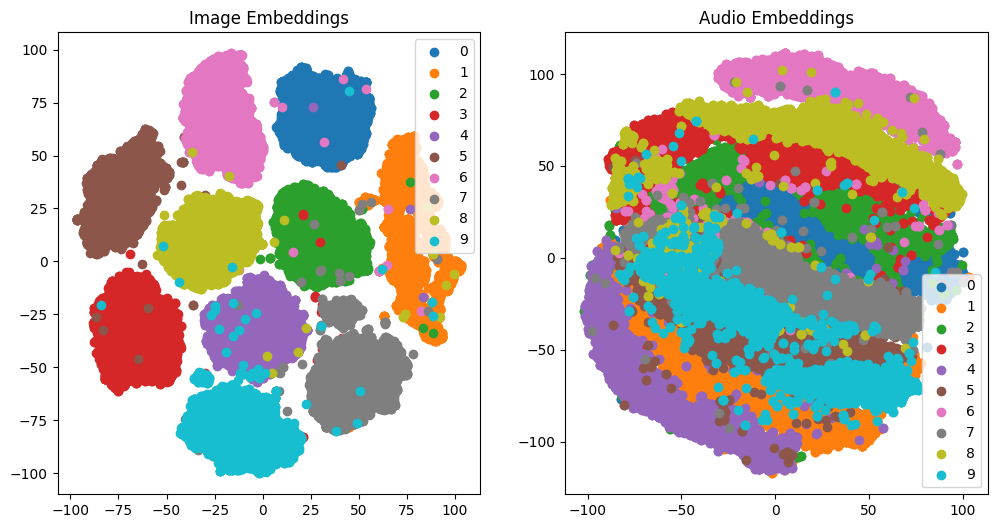

In [63]:
# Plot the embedding with labels

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
for i in range(10):
    plt.scatter(image_tsne[y_train_labels_img == i, 0], image_tsne[y_train_labels_img == i, 1], label=str(i))
plt.title('Image Embeddings')
plt.legend()

# Plot audio embeddings
plt.subplot(1, 2, 2)
for i in range(10):
    plt.scatter(audio_tsne[y_train_labels_aud == i, 0], audio_tsne[y_train_labels_aud == i, 1], label=str(i))
plt.title('Audio Embeddings')
plt.legend()

plt.show()

In [16]:
# Load Test Data
test_aud_x = np.load('x_test_sp.npy')
test_img_x = np.load('x_test_wr.npy')

In [17]:
test_x_img = test_img_x.astype("float32") / 255
test_x_img = test_x_img.reshape(-1, 28, 28)
test_x_img = np.expand_dims(test_x_img, -1)

In [18]:
predictions = new_model.predict([test_aud_x, test_x_img], verbose=0)

In [62]:
y_train_labels_img = np.argmax(y_train_img, axis=1)
y_train_labels_aud = np.argmax(y_train_aud, axis=1)

In [19]:
class_predictions = np.argmax(predictions, axis=1)

In [20]:
id = [i for i in range(10000)]

In [21]:
# Add the 2 predicted outputs to CSV
import csv

data = zip(id, class_predictions)

csv_filename = 'preds_v1.csv'

fieldnames = ['row_id', 'label']

# Write data to CSV file
with open(csv_filename, mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=fieldnames)

    writer.writeheader()

    for row in data:
        writer.writerow({fieldnames[0]: row[0], fieldnames[1]: row[1]})

print(f"CSV file '{csv_filename}' has been created successfully.")

CSV file 'preds_v7.csv' has been created successfully.
